In [ ]:
# INSTALL & FIX DEPENDENCIES
!pip install torch torchvision transformers datasets matplotlib pandas scikit-learn wordcloud
!pip install --upgrade --force-reinstall fsspec datasets

  Using cached fsspec-2025.5.1-py3-none-any.whl.metadata (11 kB)
  Using cached datasets-3.6.0-py3-none-any.whl.metadata (19 kB)
  Using cached filelock-3.18.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached numpy-2.3.1-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (62 kB)
  Using cached pyarrow-20.0.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (3.3 kB)
  Using cached dill-0.3.8-py3-none-any.whl.metadata (10 kB)
  Using cached pandas-2.3.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (91 kB)
  Using cached requests-2.32.4-py3-none-any.whl.metadata (4.9 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached xxhash-3.5.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
  Using cached multiprocess-0.70.16-py311-none-any.whl.metadata (7.2 kB)
  Using cached fsspec-2025.3.0-py3-none-any.whl.metadata (11 kB)
  Using cached huggingface_hub-0.33.2-py3-none-any.whl.metadata (14 kB)
  Using cached packaging-25.0-py

In [ ]:
# Importing Libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from datasets import load_dataset
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
import numpy as np

plt.style.use('Solarize_Light2')

In [ ]:
def pick_device():
    dvc = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("Device running:", dvc)
    return dvc

In [ ]:
def ingest_agnews(seed=123, size_train=5500, size_valid=800):
    all_data = load_dataset("ag_news")
    ag_df = pd.concat([pd.DataFrame(all_data['train']), pd.DataFrame(all_data['test'])], ignore_index=True)
    ag_df = ag_df.sample(frac=1, random_state=seed).reset_index(drop=True)
    df_fit, df_check = train_test_split(
        ag_df, train_size=size_train, test_size=size_valid, stratify=ag_df['label'], random_state=seed)
    return df_fit, df_check

In [ ]:
def visualize_classes(df, headline, palette):
    plt.figure(figsize=(5,3))
    counts = df['label'].value_counts().sort_index()
    counts.plot(kind='bar', color=palette, edgecolor='#0d1321')
    plt.xticks(range(4), ['World', 'Sports', 'Business', 'Tech'], rotation=15, fontsize=11)
    plt.title(headline, fontsize=12, fontweight='bold', color='#5603ad')
    plt.ylabel('Samples')
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_length_histogram(df, shade):
    df['textsize'] = df['text'].apply(lambda t: len(t.split()))
    plt.figure(figsize=(6,2.8))
    plt.hist(df['textsize'], bins=28, color=shade, edgecolor='#f3ffbd', alpha=0.77)
    plt.title('Word Count in News Articles', fontsize=11, color='#2b2d42')
    plt.xlabel('Word Count')
    plt.ylabel('Count')
    plt.grid(axis='y', linestyle=':', alpha=0.4)
    plt.tight_layout()
    plt.show()

In [ ]:
def draw_wordclouds(df, maps):
    for idx, title, cm in zip(range(4), ['World', 'Sports', 'Business', 'Tech'], maps):
        words = " ".join(df[df['label'] == idx]['text'])
        cloud = WordCloud(width=700, height=250, background_color='white', colormap=cm).generate(words)
        plt.figure(figsize=(7.2,2.5))
        plt.imshow(cloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'{title} Word Cloud', fontsize=12, color='#fa1e0e')
        plt.tight_layout()
        plt.show()

In [ ]:
class BatchNews(Dataset):
    def __init__(self, articles, tags, bert_tok, lim):
        self.articles = articles
        self.tags = tags
        self.bert_tok = bert_tok
        self.lim = lim
    def __len__(self): return len(self.articles)
    def __getitem__(self, j):
        enc = self.bert_tok(self.articles[j], truncation=True, padding='max_length', max_length=self.lim, return_tensors='pt')
        x = {k: v.squeeze(0) for k, v in enc.items()}
        x['labels'] = torch.tensor(self.tags[j], dtype=torch.long)
        return x


In [ ]:
def make_dataloaders(stories, labels, val_stories, val_labels, tokenizer, mxlen, bsize):
    ds_main = BatchNews(stories, labels, tokenizer, mxlen)
    ds_eval = BatchNews(val_stories, val_labels, tokenizer, mxlen)
    dl_main = DataLoader(ds_main, batch_size=bsize, shuffle=True)
    dl_eval = DataLoader(ds_eval, batch_size=bsize)
    return dl_main, dl_eval

In [ ]:
def init_bert_model(n_classes, device):
    bert = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=n_classes)
    bert = bert.to(device)
    opt = AdamW(bert.parameters(), lr=2.2e-5)
    return bert, opt

In [ ]:
def train_news_model(model, opt, dloader, device, n_epochs=3):
    model.train()
    log_losses = []
    for e in range(n_epochs):
        total = 0
        for batch in dloader:
            ids = batch['input_ids'].to(device)
            amask = batch['attention_mask'].to(device)
            labs = batch['labels'].to(device)
            opt.zero_grad()
            outs = model(input_ids=ids, attention_mask=amask, labels=labs)
            loss = outs.loss
            loss.backward()
            opt.step()
            total += loss.item()
        epoch_loss = total / len(dloader)
        log_losses.append(epoch_loss)
        print(f"Epoch {e+1}/{n_epochs} - Epoch loss: {epoch_loss:.4f}")
    return log_losses

In [ ]:
def show_loss_plot(losses, linecolor):
    plt.figure(figsize=(5.8,3.5))
    plt.plot(range(1, len(losses)+1), losses, marker='^', linestyle='-', color=linecolor, linewidth=2)
    plt.title('Training Loss Curve', fontsize=12, color='#430f58')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True, linestyle='--', alpha=0.48)
    plt.tight_layout()
    plt.show()

In [ ]:
def test_news_model(model, dataloader, device):
    model.eval()
    guesses = []
    trues = []
    with torch.no_grad():
        for batch in dataloader:
            ids = batch['input_ids'].to(device)
            amask = batch['attention_mask'].to(device)
            labs = batch['labels'].to(device)
            outs = model(input_ids=ids, attention_mask=amask)
            pred = torch.argmax(outs.logits, dim=1)
            guesses.extend(pred.cpu().numpy())
            trues.extend(labs.cpu().numpy())
    accuracy = accuracy_score(trues, guesses)
    f1 = f1_score(trues, guesses, average='weighted')
    return guesses, trues, accuracy, f1

In [ ]:
def show_confmat(y_real, y_guess, classes, cmcolor):
    cmx = confusion_matrix(y_real, y_guess)
    d = ConfusionMatrixDisplay(confusion_matrix=cmx, display_labels=classes)
    fig, ax = plt.subplots(figsize=(6,5))
    d.plot(cmap=cmcolor, ax=ax, colorbar=False)
    plt.title('Confusion Matrix', fontsize=12, color='#0b3954')
    plt.show()

In [ ]:
def show_sample_preds(articles, y_real, y_guess, names, count=5):
    print("\nSample model predictions:\n")
    for i in range(count):
        print(f"Text: {articles[i][:100]}...")
        print(f"True: {names[y_real[i]]} | Model: {names[y_guess[i]]}\n")

Device running: cuda


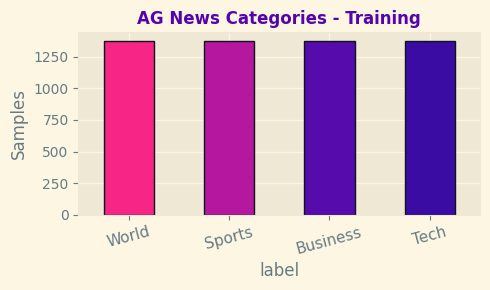

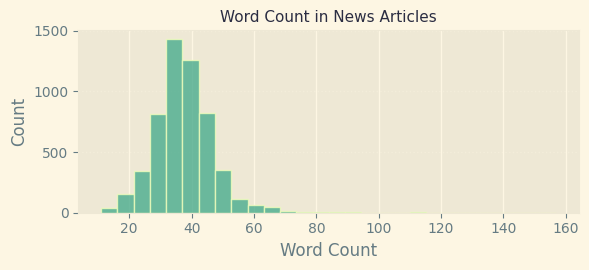

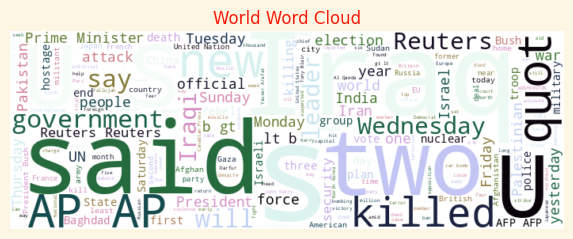

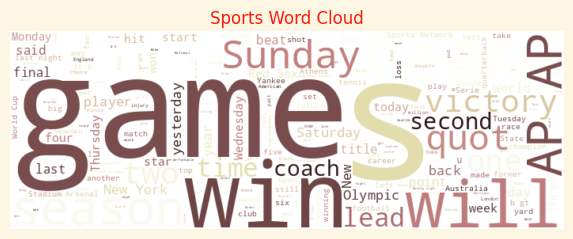

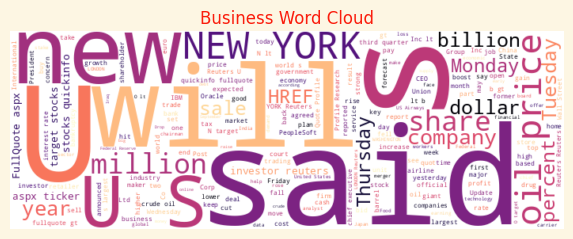

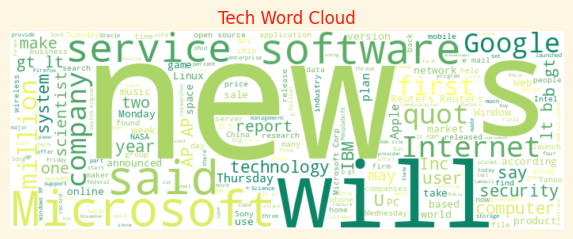

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Sample validation examples:

Text: US Businesses Urge China to Rein in Piracy BEIJING -- Seeking to bring renewed focus on a perennial trouble spot with Ch...
Label: Business

Text: EA Sees Girl Power Boost with 'Sims 2' Sales  LONDON (Reuters) - Video game giant Electronic Arts expects  to sell 2 mil...
Label: Tech

Epoch 1/10 - Epoch loss: 0.4652
Epoch 2/10 - Epoch loss: 0.2270
Epoch 3/10 - Epoch loss: 0.1371
Epoch 4/10 - Epoch loss: 0.0802
Epoch 5/10 - Epoch loss: 0.0406
Epoch 6/10 - Epoch loss: 0.0329
Epoch 7/10 - Epoch loss: 0.0329
Epoch 8/10 - Epoch loss: 0.0151
Epoch 9/10 - Epoch loss: 0.0076
Epoch 10/10 - Epoch loss: 0.0177


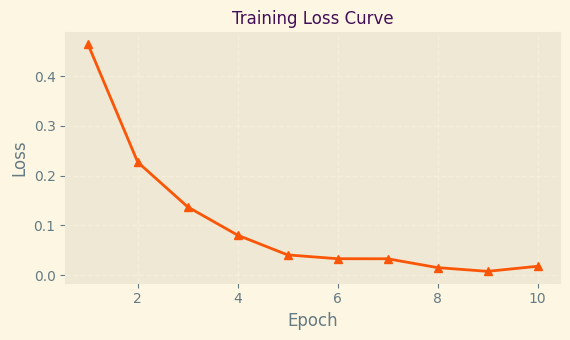


Validation Accuracy: 0.8988
Validation F1 Score: 0.8985


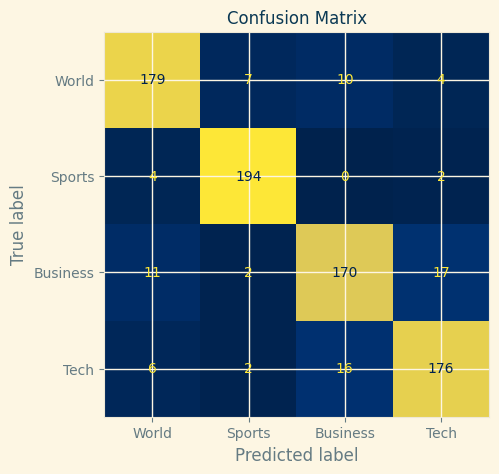


Sample model predictions:

Text: US Businesses Urge China to Rein in Piracy BEIJING -- Seeking to bring renewed focus on a perennial ...
True: Business | Model: Business

Text: EA Sees Girl Power Boost with 'Sims 2' Sales  LONDON (Reuters) - Video game giant Electronic Arts ex...
True: Tech | Model: Tech

Text: United to cut US flights, non-union pay UAL Corp. #39;s United Airlines said Friday it is following ...
True: Business | Model: Business

Text: Gates: Passwords passe Biometric and smart-card technology will replace passwords to verify ID, Micr...
True: Tech | Model: Tech

Text: Merck: Successor pill safer than Vioxx Merck  amp; Co., the US drug maker that recalled its Vioxx pa...
True: Business | Model: Business



In [ ]:
def workflow():
    mydevice = pick_device()
    dtrain, dval = ingest_agnews()
    palette_bars = ['#f72585', '#b5179e', '#560bad', '#3a0ca3']
    color_hist = '#43aa8b'
    cloud_maps = ['cubehelix', 'pink', 'magma', 'summer']
    class_list = ['World', 'Sports', 'Business', 'Tech']

    visualize_classes(dtrain, 'AG News Categories - Training', palette_bars)
    plot_length_histogram(dtrain, color_hist)
    draw_wordclouds(dtrain, cloud_maps)

    train_x = dtrain['text'].tolist()
    train_y = dtrain['label'].tolist()
    val_x = dval['text'].tolist()
    val_y = dval['label'].tolist()
    maxseq = 45
    batchsize = 20

    tok = BertTokenizer.from_pretrained('bert-base-uncased')
    dltrain, dlval = make_dataloaders(train_x, train_y, val_x, val_y, tok, maxseq, batchsize)
    bert, optim = init_bert_model(4, mydevice)

    print("\nSample validation examples:\n")
    for idx in range(2):
        print(f"Text: {val_x[idx][:120]}...\nLabel: {class_list[val_y[idx]]}\n")

    losses = train_news_model(bert, optim, dltrain, mydevice, n_epochs=10)
    show_loss_plot(losses, linecolor='#fb5607')

    pred, true, acc, f1val = test_news_model(bert, dlval, mydevice)
    print(f"\nValidation Accuracy: {acc:.4f}")
    print(f"Validation F1 Score: {f1val:.4f}")

    show_confmat(true, pred, class_list, cmcolor='cividis')
    show_sample_preds(val_x, true, pred, class_list, count=5)

workflow()